In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import numpy as np
import itertools
from itertools import permutations, combinations
import time
from pylab import *

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all

def findByRow(mat, row):
    return np.where((mat == row).all(1))[0]


# ----- Step 1: Set Hyper Parameters ----- #

NAME = 'RNN-UCR-Chinatown'
OUTPUT_CLASS = 10

RELEASE_LISTS = [
    [0,1],
    [1,0]
]
RELEASE_FACTOR = 0.1

LR = 0.001
BATCH_SIZE = 20

TIME_STEP = 24
INPUT_SIZE = 1
OUTPUT_SIZE = 2

TURNS = 150

K = 2
T = 20

K_release = K-1
T_max = T-1


# ----- Step 2: Load MNIST Dataset and Create Loader ----- #

class GetLoader(torch.utils.data.Dataset):      # 定义GetLoader类，继承Dataset方法

    def __init__(self, data_root, data_label):  # 初始化，加载数据
        self.data = data_root
        self.label = data_label

    def __getitem__(self, index):               # index是根据batchsize划分数据得到的索引
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    def __len__(self):                          # 返回数据大小长度，方便DataLoader划分
        return len(self.data)

train_data_path = '../Datasets/UCR/Chinatown/Chinatown_TRAIN.tsv'
test_data_path = '../Datasets/UCR/Chinatown/Chinatown_TEST.tsv'
    
train_text = ''
test_text = ''

train_x = []
train_y = []
test_x = []
test_y = []

with open(train_data_path, 'r') as f:
    train_text = f.read()
train_lines = train_text.split('\n')
for line in train_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        train_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        train_x.append(flo_list)

with open(test_data_path, 'r') as f:
    test_text = f.read()
test_lines = test_text.split('\n')
for line in test_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        test_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        test_x.append(flo_list)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

# 留作每50轮输出当前训练结果用
train_X = train_x.copy()
train_X = torch.from_numpy(train_X).to(torch.float32)
train_Y = train_y.copy()
test_X = torch.from_numpy(test_x).to(torch.float32)
test_Y = test_y

train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.long)
train_data = GetLoader(train_x, train_y)                # 返回Dataset对象(包含data和label)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_Y1 = train_y

y_train_onehot = torch.nn.functional.one_hot(train_Y1)


# ----- Step 3: Create Model Class ----- #

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=256,
            num_layers=3,
            batch_first=True
        )
        self.out = nn.Linear(256, OUTPUT_SIZE)

    def forward(self, x):
        r_out, _ = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])        # choose r_out at the last time step
        return out
    
    
# ----- Step 4: Instantiate ----- #

model = RNN()
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MS_loss_fn = torch.nn.MSELoss()


# ----- Step 5: Model Training ----- #

turns_record = []
loss_record = []
MS_loss_record = []
train_acc_record = []
F1_record = []
MCC_record = []
Score_record = []

total_loss_time = 0
total_MS_loss_time = 0
total_acc_time = 0
total_F1_time = 0
total_MCC_time = 0
total_Score_time = 0          

turns_index = 0
for turns in range(1, 151):
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        turns_index += 1
        
        train_x = train_x.view(-1, TIME_STEP, INPUT_SIZE)
        output = model(train_x)
        loss = loss_fn(output, train_y)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients
        
        # Shared Part - train_output
        SP_trainout_time_part_start = time.time()
        train_output = model(train_X)
        SP_trainout_time_part_stop = time.time()

        # Shared Part - softmax
        SP_softmax_time_part_start = time.time()
        train_output_result = F.softmax(train_output, dim=1)  # softmax in last dim
        SP_softmax_time_part_stop = time.time()

        # Shared Part - pred_train_y
        SP_predy_time_part_start = time.time()
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        SP_predy_time_part_stop = time.time()

        # Acc
        acc_time_part_start = time.time()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        acc_time_part_stop = time.time()

        # MS Loss
        MS_loss_time_part_start = time.time()
        MS_train_loss = MS_loss_fn(train_output_result, y_train_onehot)
        MS_loss_time_part_stop = time.time()

        # CE Loss
        loss_time_part_start = time.time()
        train_loss = loss_fn(train_output, train_Y1)
        loss_time_part_stop = time.time()

        # F1
        F1_time_part_start = time.time()
        F1 = f1_score(train_Y, pred_train_y, average='macro')
        F1_time_part_stop = time.time()

        # MCC
        MCC_time_part_start = time.time()
        MCC = matthews_corrcoef(train_Y, pred_train_y)
        MCC_time_part_stop = time.time()

        # Score
        Score_time_part_start = time.time()
        output_results = train_output_result.detach().numpy()
        prediction_pattern = np.argsort(-output_results)[:, :K]  # sorted_states_index
        confidence_pattern = T_max - np.floor((-np.sort(-output_results)[:, :K]) * T)  # sorted_states_t
        confidence_pattern[confidence_pattern == -1] = 0

        total_score = 0
        pattern_num = len(confidence_pattern)
        release_factors = np.ones((pattern_num, K))

        for i in range(pattern_num):
            current_prediction_pattern = list(prediction_pattern[i])
            if train_Y[i] in current_prediction_pattern:
                correct_index = current_prediction_pattern.index(train_Y[i])
                confidence_pattern[i][correct_index] = T_max - confidence_pattern[i][correct_index]
                release_factors[i][correct_index] = K_release

                for release_list in RELEASE_LISTS:
                    if current_prediction_pattern[correct_index] == release_list[0]:
                        for j in range(K):
                            if j != correct_index and current_prediction_pattern[j] in release_list[1:]:
                                release_factors[i][j] = RELEASE_FACTOR

        release_factors /= release_factors.sum(axis=1).reshape(-1,1)
        confidence_pattern[confidence_pattern == 0] = 1e-7
        confidence_pattern = -np.log(confidence_pattern / T_max)
        total_score = (np.multiply(release_factors, confidence_pattern).sum()) / pattern_num
        Score_time_part_stop = time.time()

        # (Test Acc)
        test_output = model(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)

        print('TURNS ID: ', turns_index, '| Acc: %.4f' % train_accuracy, '| F1: %.4f' % F1, '| MCC: %.4f' % MCC, 
              '| MS Loss: %.4f' % MS_train_loss.data.numpy(), '| CE Loss: %.4f' % train_loss.data.numpy(), 
              '| Score: %.4f' % total_score, '| Test: %.4f' % test_accuracy)

        turns_record.append(turns_index)
        loss_record.append(train_loss.data.numpy())
        MS_loss_record.append(MS_train_loss.data.numpy())
        train_acc_record.append(train_accuracy)
        F1_record.append(F1)
        MCC_record.append(MCC)
        Score_record.append(total_score)

        SP_softmax_time = (SP_softmax_time_part_stop - SP_softmax_time_part_start)
        SP_predy_time = (SP_predy_time_part_stop - SP_predy_time_part_start)
        SP_trainout_time = (SP_trainout_time_part_stop - SP_trainout_time_part_start)

        total_loss_time += ((loss_time_part_stop - loss_time_part_start) + SP_trainout_time)
        total_MS_loss_time += ((MS_loss_time_part_stop - MS_loss_time_part_start) + SP_trainout_time + SP_softmax_time)
        total_acc_time += ((acc_time_part_stop - acc_time_part_start) + SP_predy_time + SP_trainout_time)
        total_F1_time += ((F1_time_part_stop - F1_time_part_start) + SP_predy_time + SP_trainout_time)
        total_MCC_time += ((MCC_time_part_stop - MCC_time_part_start) + SP_predy_time + SP_trainout_time)
        total_Score_time += ((Score_time_part_stop - Score_time_part_start) + SP_softmax_time + SP_trainout_time)

print('\nAverage Time Cost: ', '\nAcc: %.8f' % (total_acc_time/TURNS), '\nF1: %.8f' % (total_F1_time/TURNS), 
      '\nMCC: %.8f' % (total_MCC_time/TURNS), '\nMS Loss: %.8f' % (total_MS_loss_time/TURNS), 
      '\nCE Loss: %.8f' % (total_loss_time/TURNS), '\nScore: %.8f' % (total_Score_time/TURNS))      


RNN(
  (rnn): RNN(1, 256, num_layers=3, batch_first=True)
  (out): Linear(in_features=256, out_features=2, bias=True)
)
TURNS ID:  1 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.4395 | CE Loss: 1.4025 | Score: 1.4993 | Test: 0.7259
TURNS ID:  2 | Acc: 0.5000

D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2782 | CE Loss: 0.7529 | Score: 0.7661 | Test: 0.7259
TURNS ID:  3 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.3033 | CE Loss: 0.8130 | Score: 0.8202 | Test: 0.2741
TURNS ID:  4 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2941 | CE Loss: 0.7901 | Score: 0.8202 | Test: 0.2741


D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


TURNS ID:  5 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2465 | CE Loss: 0.6860 | Score: 0.6814 | Test: 0.2741
TURNS ID:  6 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2658 | CE Loss: 0.7259 | Score: 0.7244 | Test: 0.7259
TURNS ID:  7 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2775 | CE Loss: 0.7515 | Score: 0.7661 | Test: 0.7259


D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


TURNS ID:  8 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2589 | CE Loss: 0.7113 | Score: 0.7157 | Test: 0.7259
TURNS ID:  9 | Acc: 0.6500 | F1: 0.6267 | MCC: 0.3464 | MS Loss: 0.2432 | CE Loss: 0.6795 | Score: 0.6787 | Test: 0.7318


D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


TURNS ID:  10 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2481 | CE Loss: 0.6890 | Score: 0.6892 | Test: 0.2741
TURNS ID:  11 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2552 | CE Loss: 0.7034 | Score: 0.7097 | Test: 0.2741
TURNS ID:  12 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2501 | CE Loss: 0.6928 | Score: 0.6887 | Test: 0.2741
TURNS ID:  13 | Acc: 0.5500 | F1: 0.4357 | MCC: 0.2294 | MS Loss: 0.2390 | CE Loss: 0.6707 | Score: 0.6633 | Test: 0.3090
TURNS ID:  14 | Acc: 0.6500 | F1: 0.6419 | MCC: 0.3145 | MS Loss: 0.2340 | CE Loss: 0.6610 | Score: 0.6667 | Test: 0.7143
TURNS ID:  15 | Acc: 0.5500 | F1: 0.4357 | MCC: 0.2294 | MS Loss: 0.2366 | CE Loss: 0.6660 | Score: 0.6695 | Test: 0.7259


D:\Download\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


TURNS ID:  16 | Acc: 0.5000 | F1: 0.3333 | MCC: 0.0000 | MS Loss: 0.2366 | CE Loss: 0.6657 | Score: 0.6705 | Test: 0.7259
TURNS ID:  17 | Acc: 0.6500 | F1: 0.6419 | MCC: 0.3145 | MS Loss: 0.2289 | CE Loss: 0.6503 | Score: 0.6568 | Test: 0.7172
TURNS ID:  18 | Acc: 0.7000 | F1: 0.6970 | MCC: 0.4082 | MS Loss: 0.2198 | CE Loss: 0.6322 | Score: 0.6363 | Test: 0.6968
TURNS ID:  19 | Acc: 0.7500 | F1: 0.7494 | MCC: 0.5025 | MS Loss: 0.2160 | CE Loss: 0.6241 | Score: 0.6250 | Test: 0.6414
TURNS ID:  20 | Acc: 0.7500 | F1: 0.7494 | MCC: 0.5025 | MS Loss: 0.2148 | CE Loss: 0.6209 | Score: 0.6036 | Test: 0.5773
TURNS ID:  21 | Acc: 0.7500 | F1: 0.7494 | MCC: 0.5025 | MS Loss: 0.2101 | CE Loss: 0.6113 | Score: 0.6204 | Test: 0.6181
TURNS ID:  22 | Acc: 0.7500 | F1: 0.7494 | MCC: 0.5025 | MS Loss: 0.2043 | CE Loss: 0.5990 | Score: 0.6042 | Test: 0.6706
TURNS ID:  23 | Acc: 0.7000 | F1: 0.6970 | MCC: 0.4082 | MS Loss: 0.2023 | CE Loss: 0.5942 | Score: 0.5918 | Test: 0.6968
TURNS ID:  24 | Acc: 0.7

TURNS ID:  85 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0009 | CE Loss: 0.0177 | Score: 0.0056 | Test: 0.8863
TURNS ID:  86 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0004 | CE Loss: 0.0127 | Score: 0.0027 | Test: 0.9155
TURNS ID:  87 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0002 | CE Loss: 0.0108 | Score: 0.0000 | Test: 0.9329
TURNS ID:  88 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0002 | CE Loss: 0.0099 | Score: 0.0027 | Test: 0.9388
TURNS ID:  89 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0002 | CE Loss: 0.0085 | Score: 0.0000 | Test: 0.9446
TURNS ID:  90 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0001 | CE Loss: 0.0068 | Score: 0.0000 | Test: 0.9475
TURNS ID:  91 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0001 | CE Loss: 0.0054 | Score: 0.0000 | Test: 0.9504
TURNS ID:  92 | Acc: 1.0000 | F1: 1.0000 | MCC: 1.0000 | MS Loss: 0.0000 | CE Loss: 0.0048 | Score: 0.0000 | Test: 0.9504
TURNS ID:  93 | Acc: 1.0

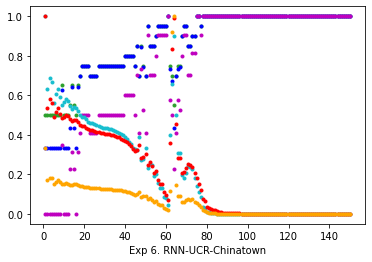

In [2]:
# loss 归一化
max_loss = 0
max_MS_loss = 0
max_train_acc = 0
max_F1 = 0
max_MCC = 0
max_Score = 0

for i in range(len(turns_record)):
    if loss_record[i] > max_loss:
        max_loss = loss_record[i]
    if MS_loss_record[i] > max_MS_loss:
        max_MS_loss = MS_loss_record[i]
    if Score_record[i] > max_Score:
        max_Score = Score_record[i]    

for i in range(len(loss_record)):
    loss_record[i] = loss_record[i]/max_loss
    MS_loss_record[i] = MS_loss_record[i]/max_MS_loss
    Score_record[i] = Score_record[i]/max_Score
    
plt.plot(turns_record, train_acc_record, '.', color = 'tab:green', label='ACC')
plt.plot(turns_record, F1_record, '.', color = 'b', label='F1') # lightpink
plt.plot(turns_record, MCC_record, '.', color = 'm', label='MCC')
plt.plot(turns_record, MS_loss_record, '.', color = 'tab:cyan', label='MS') # turquoise
plt.plot(turns_record, loss_record, '.', color = 'r', label='CE') # blueviolet
plt.plot(turns_record, Score_record, '.', color = 'orange', label='MPWS')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

LABEL = 'Exp 6'
plt.xlabel(f"{LABEL}. {NAME}")

plt.savefig(f'../Savefig/{LABEL}.png', bbox_inches='tight', dpi=600)  # 保存该图片
plt.show()

In [3]:
import pandas as pd

train_acc_record_df = pd.DataFrame(train_acc_record)
F1_record_df = pd.DataFrame(F1_record)
MCC_record_df = pd.DataFrame(MCC_record)
MS_loss_record_df = pd.DataFrame(MS_loss_record)
loss_record_df = pd.DataFrame(loss_record)
Score_record_df = pd.DataFrame(Score_record)

data_df = pd.concat([train_acc_record_df, F1_record_df, MCC_record_df, MS_loss_record_df, loss_record_df, Score_record_df], axis=1)
data_df.columns = ['Accuracy', 'F1-score', 'MCC', 'Mean Squared', 'Cross Entropy', 'MPWS']  # head

writer = pd.ExcelWriter(f"../Records/{LABEL}. {NAME}.xlsx")
data_df.to_excel(writer,'page_1')
writer.save()

